In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Load data
ted = pd.read_csv("ted_main.csv")
to_drop = ['name', 'main_speaker', 'related_talks','url'] # name is merely main_speaker + title, so will be dropped
ted = ted.drop(to_drop, axis='columns')

print ted.head()

   comments                                        description  duration  \
0      4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1       265  With the same humor and humanity he exuded in ...       977   
2       124  New York Times columnist David Pogue takes aim...      1286   
3       200  In an emotionally charged talk, MacArthur-winn...      1116   
4       593  You've never seen data presented like this. Wi...      1190   

     event   film_date  languages  num_speaker  published_date  \
0  TED2006  1140825600         60            1      1151367060   
1  TED2006  1140825600         43            1      1151367060   
2  TED2006  1140739200         26            1      1151367060   
3  TED2006  1140912000         35            1      1151367060   
4  TED2006  1140566400         48            1      1151440680   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'co

In [2]:
# print ted.head()
print "No. of lines: ", len(ted)

No. of lines:  2550


In [3]:
# Categorize events into TED and TEDx; exclude those that are non-TED events
ted = ted[ted['event'].str[0:3]=='TED']
ted.loc[:,'event_cat'] = ted['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')

print "No. of talks remain: ", len(ted)

No. of talks remain:  2439


In [4]:
# Change Unix timestamp to human readable date format
# Extract month and day of week from film date and published date
import datetime

ted['film_date'] = ted['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['published_date'] = ted['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['film_month'] = ted['film_date'].apply(lambda x: x.month)
ted['pub_month'] = ted['published_date'].apply(lambda x: x.month)
ted['film_weekday'] = ted['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
ted['pub_weekday'] = ted['published_date'].apply(lambda x: x.weekday())
for col in ['film_month', 'pub_month', 'film_weekday', 'pub_weekday']:
    ted[col] = ted[col].astype('category')
# display(ted.info())

In [5]:
# Convert ratings column into one column for each rating
# The following piece of code is adopted from https://www.kaggle.com/allpower/are-co-presented-talks-more-successful
ted['ratings']=ted['ratings'].str.replace("'",'"')
ted=ted.merge(ted.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

In [6]:
# Get labels
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']
ted['positive']=ted.loc[:,Positive].sum(axis=1)+1
ted['negative']=ted.loc[:,Negative].sum(axis=1)+1
ted['pos_ratio']=ted['positive']/ted['negative']
ted.loc[:,'Popular'] = ted['pos_ratio'].apply (lambda x: 1 if x >5 else 0)

print "No. of Not Popular talks: ", len(ted[ted['Popular']==0])
print "Ratio of Popular talks: {:.4f}".format(len(ted[ted['Popular']==1])/ float(len(ted)))

No. of Not Popular talks:  301
Ratio of Popular talks: 0.8766


In [7]:
# Categorize num_speaker into "single" and "multiple"
ted.loc[:,'single_speaker'] = ted['num_speaker'].apply (lambda x: 1 if x==1 else 0)
print "No. of multiple-speaker talks: ", len(ted[ted['single_speaker']==0])

No. of multiple-speaker talks:  58


In [8]:
# Show inputs before processing text columns
input_columns = ['comments', 'duration', 'languages', 'views', 'film_month', 'pub_month', 'film_weekday', 'pub_weekday',  
                 'event_cat', 'single_speaker']
display(ted.loc[:,input_columns].head(5))

,comments,duration,languages,views,film_month,pub_month,film_weekday,pub_weekday,event_cat,single_speaker
0,4553,1164,60,47227110,2,6,5,1,TED,1
1,265,977,43,3200520,2,6,5,1,TED,1
2,124,1286,26,1636292,2,6,4,1,TED,1
3,200,1116,35,1697550,2,6,6,1,TED,1
4,593,1190,48,12005869,2,6,2,2,TED,1


In [9]:
# Analysis of tags
# The following piece of code is adapted from https://www.kaggle.com/lpang36/analysis-of-ted-talk-ratings
ted['tags'] = ted['tags'].apply(lambda x:eval(str(x)))
all_tags = {}
for talk in ted['tags']:
    for tag in talk:
        if not tag in all_tags:
            all_tags[tag] = 1
        else:
            all_tags[tag] += 1
tags_df = pd.DataFrame.from_dict(all_tags, orient = 'index').reset_index()
tags_df.columns = ['tag','frequency']
toptags = tags_df[tags_df['frequency']>=20].sort_values('frequency', ascending=False) # Analyze tags with 20 or above occurences
print toptags.head(20)
print "Total tags with 20 or more occurences: ", len(toptags)

               tag  frequency
295     technology        701
72         science        534
313  global issues        478
243        culture        473
377           TEDx        450
36          design        397
357       business        332
134  entertainment        276
136         health        233
354     innovation        224
130        society        222
149  social change        216
239            art        206
183         future        191
373  communication        189
355        biology        180
276     creativity        179
329       humanity        176
205  collaboration        173
137       medicine        160
Total tags with 20 or more occurences:  209


In [10]:
# Create dataframe to collect inputs from text columns
df = ted.loc[:,['Popular']]

taglist = toptags['tag'].tolist()
for tag in taglist:
    tag_col = 'tag_'+tag
    df[tag_col] = ted['tags'].apply(lambda x: x.count(tag))

print df.shape

(2439, 210)


In [11]:
# Analysis of speaker occupation - convert into tags
import re

ted['occupation_tag'] = ted['speaker_occupation'].apply(lambda x: str(x).lower().strip())

# Manipulating singer/songwriter
ted['occupation_tag'] = ted['occupation_tag'].str.replace('singer/songwriter', 'singer, songwriter')
ted['occupation_tag'] = ted['occupation_tag'].str.replace('singer-songwriter', 'singer, songwriter')

# Multiple occupations are expressed in ', ', '; ' or ' and '
ted['occupation_tag'] = ted['occupation_tag'].apply(lambda x: re.split(',\s|;\s|\sand\s', x))

# Assigning 'activist' label to all kinds of 'x activist'; same for 'x author', 'x writer', 'x artist'
target = ['activist', 'author', 'writer', 'artist']
def act_add(occ_list, target):
    for word in target:
        if occ_list.count(word) == 0:
            for occ in occ_list:
                if occ.count(' ' + word) > 0:
                    occ_list.append(word)
                    break
    return occ_list
ted['occupation_tag'] = ted['occupation_tag'].apply(lambda x: act_add(x, target))

In [12]:
all_occ = {}
for talk in ted['occupation_tag']:
    for occupation in talk:
        if not occupation in all_occ:
            all_occ[occupation] = 1
        else:
            all_occ[occupation] += 1
occ_df = pd.DataFrame.from_dict(all_occ, orient = 'index').reset_index()
occ_df.columns = ['Occupation','frequency']
topjobs = occ_df[occ_df['frequency']>=20].sort_values('frequency', ascending=False)

print 'Total jobs with 20 or more occurrence: ', len(topjobs)
print topjobs.head(20)

Total jobs with 20 or more occurrence:  24
          Occupation  frequency
417         activist        139
683           artist        102
644           writer         99
880           author         77
265         designer         55
1101    entrepreneur         53
1052      journalist         50
518         inventor         48
567         educator         44
531        architect         35
47      psychologist         34
378   neuroscientist         31
1040     philosopher         31
966     photographer         28
827        filmmaker         28
198         musician         26
745        physicist         26
815             poet         25
633        economist         25
955        biologist         24


In [13]:
# Convert into dummy variables
joblist = topjobs['Occupation'].tolist()
for job in joblist:
    job_col = 'occ_'+job
    df[job_col] = ted['occupation_tag'].apply(lambda x: 1 if x.count(job)>0 else 0)
print df.shape

(2439, 234)


In [14]:
# Description - word counts
df['des_wc'] = ted['description'].apply(lambda x: len(x.split()))
print "Total words in description: ", sum(df['des_wc'])

Total words in description:  127471


In [15]:
# Titles - word count
df['title_wc'] = ted['title'].apply(lambda x: len(x.split()))
df['title_wc2'] = df['title_wc'].apply(lambda x: x**2)
print "Total words in titles: ", sum(df['title_wc'])

# Title - whether it is a question
from nltk import word_tokenize
ted['title_tokens'] = ted['title'].apply(lambda x: str(x).lower().decode('utf-8').strip())
ted['title_tokens'] = ted['title_tokens'].apply (lambda x: word_tokenize(x))

# print ted['title_tokens'].head(10)
q_tokens = ['what', 'how', 'when', 'why', 'which', 'where', '?']
def title_question(word_tokens, q_tokens):
    q_count = 0
    for word in q_tokens:
        q_count = q_count + word_tokens.count(word)
    return 1 if q_count > 0 else 0

df['title_is_q'] = ted['title_tokens'].apply(lambda x: title_question(x, q_tokens))
print df.shape

Total words in titles:  15268
(2439, 238)


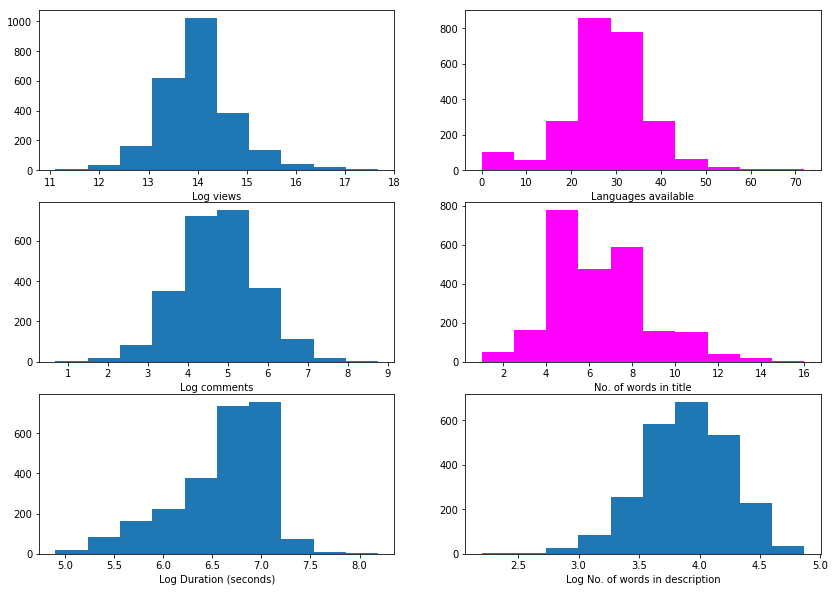

In [16]:
# Histograms of numerical values
plt.rcParams["figure.figsize"] = [14,10]
fig, ax = plt.subplots(3,2)
ax[0,0].hist(np.log(ted['views']))
ax[0,0].set_xlabel('Log views')
ax[1,0].hist(np.log(ted['comments']))
ax[1,0].set_xlabel('Log comments')
ax[2,0].hist(np.log(ted['duration']))
ax[2,0].set_xlabel('Log Duration (seconds)')
ax[0,1].hist(ted['languages'], color='magenta')
ax[0,1].set_xlabel('Languages available')
ax[1,1].hist(df['title_wc'], color='magenta')
ax[1,1].set_xlabel('No. of words in title')
ax[2,1].hist(np.log(df['des_wc']))
ax[2,1].set_xlabel('Log No. of words in description')
plt.savefig('histogram.png')
plt.show()

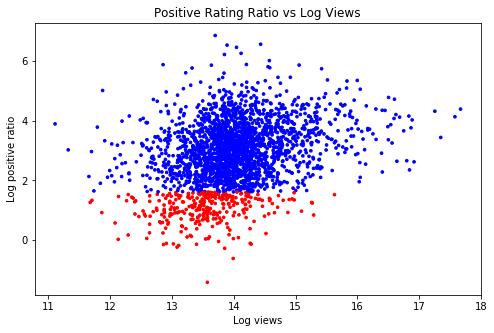

In [16]:
# EDA - Views
cmap = {1: 'blue', 0: 'red'}
colors = ted.Popular.map(cmap)
plt.rcParams["figure.figsize"] = [8,5]
plt.scatter(x=np.log(ted['views']), y=np.log(ted['pos_ratio']), c = colors, s=7)
plt.title("Positive Rating Ratio vs Log Views")
plt.xlabel("Log views")
plt.ylabel("Log positive ratio")
plt.savefig('eda_view.png', bbox_inches='tight')
plt.show()

In [17]:
print 'Maximum view of unpopular talk: ', ted[ted['Popular']==0].views.max()

Maximum view of unpopular talk:  6141440


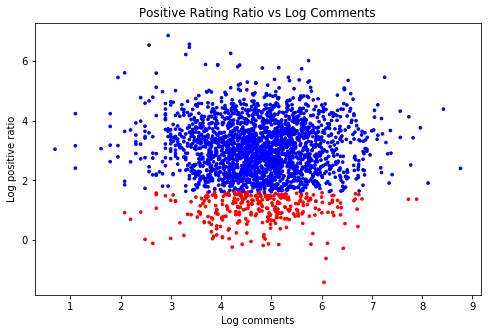

In [18]:
# Comments
plt.scatter(x=np.log(ted['comments']), y=np.log(ted['pos_ratio']), c=colors, s=7)
plt.title("Positive Rating Ratio vs Log Comments")
plt.xlabel("Log comments")
plt.ylabel("Log positive ratio")
plt.savefig('eda_comment.png', bbox_inches='tight')
plt.show()

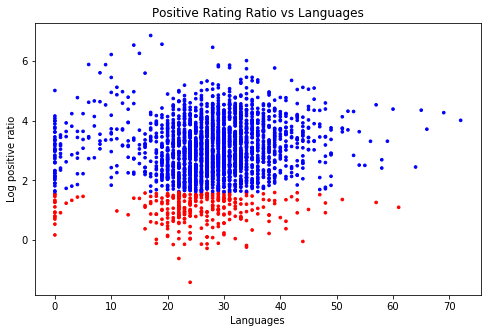

In [19]:
# Languages
plt.scatter(x=ted['languages'], y=np.log(ted['pos_ratio']), c=colors, s=7)
plt.title("Positive Rating Ratio vs Languages")
plt.xlabel("Languages")
plt.ylabel("Log positive ratio")
plt.savefig('eda_language.png', bbox_inches='tight')
plt.show()

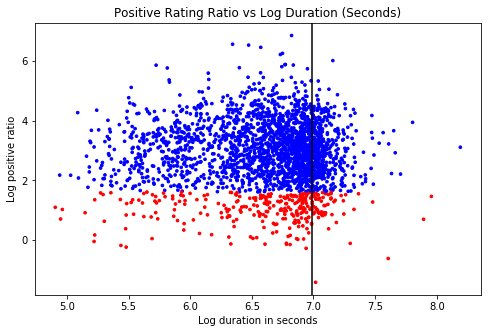

In [20]:
# Duration
plt.scatter(np.log(ted['duration']),np.log(ted['pos_ratio']), c=colors, s=7)
plt.axvline(np.log(18*60),color='black')
plt.title("Positive Rating Ratio vs Log Duration (Seconds)")
plt.xlabel("Log duration in seconds")
plt.ylabel("Log positive ratio")
plt.savefig('eda_duration.png', bbox_inches='tight')
plt.show()

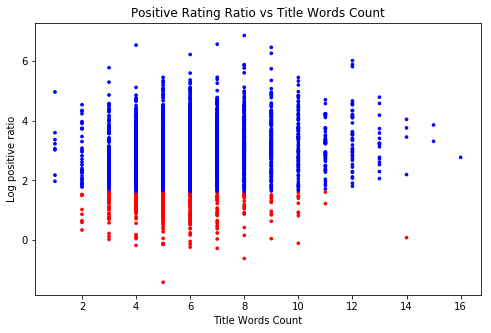

In [21]:
# EDA - word counts of title
plt.scatter(df['title_wc'],np.log(ted['pos_ratio']), c=colors, s=7)
plt.title("Positive Rating Ratio vs Title Words Count")
plt.xlabel("Title Words Count")
plt.ylabel("Log positive ratio")
plt.savefig('eda_title.png', bbox_inches='tight')
plt.show()

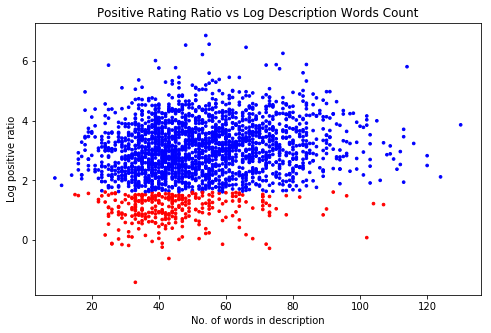

In [22]:
# EDA - word counts of description
plt.scatter(df['des_wc'],np.log(ted['pos_ratio']), c=colors, s=7)
plt.title("Positive Rating Ratio vs Log Description Words Count")
plt.xlabel("No. of words in description")
plt.ylabel("Log positive ratio")
plt.savefig('eda_des.png', bbox_inches='tight')
plt.show()

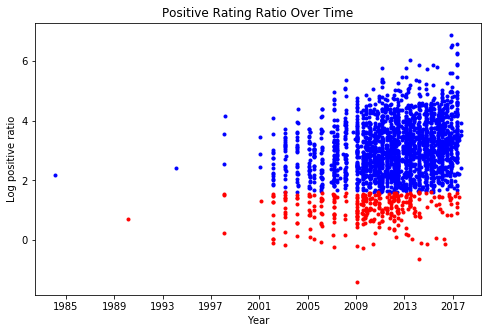

In [23]:
# view against time
plt.rcParams["figure.figsize"] = [8,5]
plt.plot_date(ted[ted['Popular']==1]['film_date'], np.log(ted[ted['Popular']==1]['pos_ratio']), c = 'blue', ms=3)
plt.plot_date(ted[ted['Popular']==0]['film_date'], np.log(ted[ted['Popular']==0]['pos_ratio']), c = 'red', ms=3)
plt.title("Positive Rating Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Log positive ratio")
plt.savefig('eda_year.png', bbox_inches='tight')
plt.show()

In [24]:
# Speakers
print ted.groupby('single_speaker')['Popular'].mean()

single_speaker
0    0.862069
1    0.876942
Name: Popular, dtype: float64


In [25]:
# Event category
print ted.groupby('event_cat')['Popular'].mean()

event_cat
TED     0.871951
TEDx    0.895966
Name: Popular, dtype: float64


In [26]:
# film_month
fm = ted.groupby('film_month')['Popular'].mean()
pm = ted.groupby('pub_month')['Popular'].mean()
display(pd.concat([fm, pm], axis=1))

,Popular,Popular
1,0.965517,0.870000
2,0.821369,0.881443
3,0.896203,0.900452
4,0.894737,0.845528
5,0.935185,0.882353
6,0.894737,0.873874
7,0.858300,0.868687
8,0.827586,0.900585
9,0.910891,0.874439
10,0.909574,0.853774


In [27]:
# film_weekday
fw = ted.groupby('film_weekday')['Popular'].mean()
pw = ted.groupby('pub_weekday')['Popular'].mean()
display(pd.concat([fw, pw], axis=1))

,Popular,Popular
0,0.905724,0.829609
1,0.895570,0.884615
2,0.893910,0.890351
3,0.869811,0.875000
4,0.878788,0.885650
5,0.813880,0.883721
6,0.869159,0.920000


In [28]:
# Analyze text fields
text_col = df.drop(['Popular','des_wc','title_wc', 'title_wc2'], axis='columns').columns
text_df = pd.DataFrame(index=[0,1], columns = text_col)
for col in text_col:
    result = df.groupby(col)['Popular'].mean()
    text_df[col] = result
text_df = text_df.transpose()
print "Most Popular"
display(text_df.sort_values(1, ascending=False).head(10)[1])
print "Least Popular"
display(text_df.sort_values(1).head(10)[1])

Most Popular


tag_Senses            1.000000
tag_physiology        1.000000
tag_depression        1.000000
tag_empathy           1.000000
tag_gender            1.000000
tag_water             1.000000
tag_success           1.000000
occ_neuroscientist    1.000000
tag_potential         0.986301
tag_oceans            0.980392
Name: 1, dtype: float64

Least Popular


tag_cars                 0.550000
occ_economist            0.720000
tag_industrial design    0.724138
tag_security             0.725000
tag_religion             0.740000
occ_philosopher          0.741935
occ_designer             0.745455
tag_dance                0.750000
tag_gaming               0.750000
tag_illusion             0.750000
Name: 1, dtype: float64

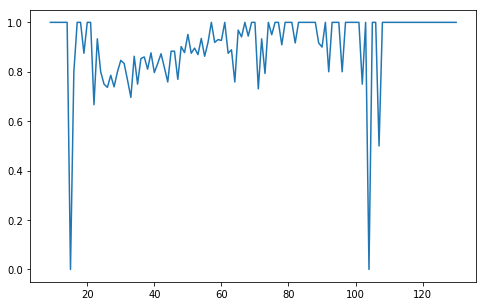

In [29]:
plt.plot(df.groupby('des_wc')['Popular'].mean())
plt.show()

In [30]:
# Split training and testing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

# Columns for benchmark models - features without text columns
input_columns = ['duration', 'languages', 'film_month', 'pub_month', 'film_weekday', 'pub_weekday',  
                 'event_cat', 'single_speaker'] # remove 'comments' and 'views'
inputs_raw = ted.loc[:, input_columns]
for col in ['duration']:
    inputs_raw[col] = np.log(inputs_raw[col])
for col in ['duration', 'languages']:
    # inputs_raw[col] = scale(inputs_raw[col])
    inputs_raw[col] = scaler.fit_transform(inputs_raw[[col]])

bmm_inputs = pd.get_dummies(inputs_raw) # All inputs for benchmark model
# Remove redundant columns to avoid multicollinearity
bmm_inputs = bmm_inputs.drop(['film_month_12', 'film_weekday_6', 'pub_month_12', 'pub_weekday_6', 'event_cat_TEDx'], axis='columns')  
print bmm_inputs.shape

# All features including text columns
all_inputs = pd.concat([df.drop('Popular', axis='columns'), bmm_inputs], axis=1)
# all_inputs['title_wc'] = scale(all_inputs['title_wc']) # standardize title word counts
all_inputs['title_wc'] = scaler.fit_transform(all_inputs[['title_wc']])
all_inputs['title_wc2'] = scaler.fit_transform(all_inputs[['title_wc2']])
all_inputs['des_wc'] = np.log(all_inputs['des_wc']) # standardize log tranform of description word counts
all_inputs['des_wc'] = scaler.fit_transform(all_inputs[['des_wc']])
print all_inputs.shape

# Labels
labels = ted.loc[:,'Popular']

(2439, 38)
(2439, 275)


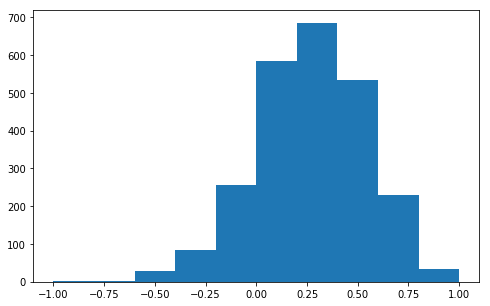

In [31]:
plt.hist(all_inputs['des_wc'])
plt.show()

In [32]:
# Splitting training and testing data for benchmark and target model
bm_X_train, bm_X_test, bm_y_train, bm_y_test = train_test_split(bmm_inputs, labels, test_size=0.25, random_state=108)
X_train, X_test, y_train, y_test = train_test_split(all_inputs, labels, test_size=0.25, random_state=108)

In [33]:
print len(X_train)
print len(X_test)

1829
610


In [34]:
# Benchmark model: Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score

bm_model = LogisticRegression(random_state = 108)
bm_model.fit(bm_X_train, bm_y_train)
print "Benchmark model accuracy: {:.4f}".format(bm_model.score(bm_X_test, bm_y_test))
y_pred = bm_model.predict(bm_X_test)
print "F1-score of benchmark model: {:.4f}".format(fbeta_score(bm_y_test, y_pred, beta=1))
print confusion_matrix(y_test, y_pred)

Benchmark model accuracy: 0.8705
F1-score of benchmark model: 0.9308
[[  0  77]
 [  2 531]]


In [35]:
pd.DataFrame(np.transpose(bm_model.coef_), index=bm_X_train.columns)

,0
duration,0.635148
languages,1.674338
single_speaker,0.202299
film_month_1,0.865374
film_month_2,-0.592995
film_month_3,-0.006704
film_month_4,-0.183536
film_month_5,0.246395
film_month_6,0.120618
film_month_7,-0.418354


In [36]:
# Complete model: Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
print "Benchmark model accuracy: {:.4f}".format(nb_model.score(X_test, y_test))
y_pred = nb_model.predict(X_test) 
print "F1-score of benchmark model: {:.4f}".format(fbeta_score(y_test, y_pred, beta=1))
print confusion_matrix(y_test, y_pred)

Benchmark model accuracy: 0.3164
F1-score of benchmark model: 0.3748
[[ 68   9]
 [408 125]]


In [37]:
# Write function on training and testing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def train_predict(clf, parameters):
        
    clf.fit(X_train, y_train)
    scorer = make_scorer(fbeta_score, beta=1)
    # 5-fold cross validation
    start = time()

    grid_obj = GridSearchCV(clf, parameters, cv=5, scoring=scorer)
    grid_fit = grid_obj.fit(X_train, y_train)
    best_clf = grid_fit.best_estimator_
    y_pred = clf.predict(X_test)
    best_predictions = best_clf.predict(X_test)

    end = time()

    run_time = end - start

    # Report results
    print clf.__class__.__name__ + ":"
    print "Accuracy score on testing data (default parameters): {:.4f}".format(clf.score(X_test, y_test))
    print "F1-score on testing data (default parameters): {:.4f}".format(fbeta_score(y_test, y_pred, beta = 1))
    print "Default model:\n" + str(clf.get_params())
    print confusion_matrix(y_test, y_pred)
    print "Accuracy score on testing data (optimized by grid-search CV): {:.4f}".format(best_clf.score(X_test, y_test))
    print "F1-score on testing data (optimized by grid-search CV): {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1))
    print "Parameters: ", grid_fit.best_params_
    print confusion_matrix(y_test, best_predictions)
    print "Total runtime: {:.4f} seconds".format(run_time)

In [38]:
# Logistic Regression
clf = LogisticRegression(random_state = 108)
parameters = {'C': [0.01, 0.05, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
train_predict(clf, parameters)

/home/holfyuen/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression:
Accuracy score on testing data (default parameters): 0.8590
F1-score on testing data (default parameters): 0.9236
Default model:
{'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 108, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}
[[  4  73]
 [ 13 520]]
Accuracy score on testing data (optimized by grid-search CV): 0.8738
F1-score on testing data (optimized by grid-search CV): 0.9326
Parameters:  {'C': 0.01, 'solver': 'newton-cg'}
[[  0  77]
 [  0 533]]
Total runtime: 21.5487 seconds


In [39]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 108)
parameters = {'criterion': ['gini', 'entropy'], 'max_features': [None, 'auto', 'log2'], 'min_samples_split': [2,3,5]}
train_predict(clf, parameters)

DecisionTreeClassifier:
Accuracy score on testing data (default parameters): 0.7951
F1-score on testing data (default parameters): 0.8837
Default model:
{'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 108, 'min_impurity_split': None, 'max_features': None, 'max_depth': None, 'class_weight': None}
[[ 10  67]
 [ 58 475]]
Accuracy score on testing data (optimized by grid-search CV): 0.7934
F1-score on testing data (optimized by grid-search CV): 0.8816
Parameters:  {'max_features': None, 'min_samples_split': 3, 'criterion': 'entropy'}
[[ 15  62]
 [ 64 469]]
Total runtime: 7.1985 seconds


In [40]:
# Support Vector Machine
from sklearn.svm import SVC
clf = SVC(random_state = 108)
parameters = {'C': [0.05, 0.1, 0.5, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3]}
train_predict(clf, parameters)

SVC:
Accuracy score on testing data (default parameters): 0.8738
F1-score on testing data (default parameters): 0.9326
Default model:
{'kernel': 'rbf', 'C': 1.0, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': 'ovr', 'random_state': 108, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto', 'class_weight': None}
[[  0  77]
 [  0 533]]
Accuracy score on testing data (optimized by grid-search CV): 0.8738
F1-score on testing data (optimized by grid-search CV): 0.9326
Parameters:  {'kernel': 'linear', 'C': 0.05, 'degree': 2}
[[  0  77]
 [  0 533]]
Total runtime: 265.9068 seconds


In [44]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 108)
parameters = {'n_estimators': [5, 10, 15], 'criterion': ['gini', 'entropy'], 'max_features': [None, 'auto', 'log2'], 
              'min_samples_split': [2,3,5]}
train_predict(clf, parameters)

RandomForestClassifier:
Accuracy score on testing data (default parameters): 0.8672
F1-score on testing data (default parameters): 0.9286
Default model:
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 108, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}
[[  2  75]
 [  6 527]]
Accuracy score on testing data (optimized by grid-search CV): 0.8754
F1-score on testing data (optimized by grid-search CV): 0.9335
Parameters:  {'max_features': 'auto', 'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 15}
[[  1  76]
 [  0 533]]
Total runtime: 120.4718 seconds


In [67]:
# Checking prediction results only
clf_rf = RandomForestClassifier(random_state = 108, max_features = 'auto', min_samples_split = 5, criterion = 'gini', n_estimators=15)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print list(y_pred_rf).index(0)
print y_pred_rf[70]
print y_test.iloc[70,]
print X_test.iloc[70:71,:]

70
0
0
    tag_technology  tag_science  tag_global issues  tag_culture  tag_TEDx  \
75               1            0                  0            0         0   

    tag_design  tag_business  tag_entertainment  tag_health  tag_innovation  \
75           1             1                  0           0               0   

        ...        film_weekday_3  film_weekday_4  film_weekday_5  \
75      ...                     0               0               1   

    pub_weekday_0  pub_weekday_1  pub_weekday_2  pub_weekday_3  pub_weekday_4  \
75              0              0              0              1              0   

    pub_weekday_5  event_cat_TED  
75              0              1  

[1 rows x 275 columns]


In [77]:
display(ted.loc[75, :])
print ted.loc[75,'tags']

comments                                                             78
description           American designer Chris Bangle explains his ph...
duration                                                           1204
event                                                           TED2002
film_date                                                    2002-02-02
languages                                                            23
num_speaker                                                           1
published_date                                               2007-04-05
ratings               [{"id": 1, "name": "Beautiful", "count": 88}, ...
speaker_occupation                                         Car designer
tags                  [art, business, cars, design, industrial desig...
title                                          Great cars are great art
views                                                            867495
event_cat                                                       

['art', 'business', 'cars', 'design', 'industrial design', 'invention', 'technology', 'transportation']


In [42]:
# Neural network - with cross validation
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 108, early_stopping=True)
parameters = {'hidden_layer_sizes': [(4,), (8, ), (16,), (32,)], 'activation': ['logistic', 'tanh', 'relu'], 
              'learning_rate_init': [0.001, 0.01, 0.1, 1]}
train_predict(clf, parameters)

MLPClassifier:
Accuracy score on testing data (default parameters): 0.8705
F1-score on testing data (default parameters): 0.9308
Default model:
{'beta_1': 0.9, 'warm_start': False, 'beta_2': 0.999, 'shuffle': True, 'verbose': False, 'nesterovs_momentum': True, 'hidden_layer_sizes': (100,), 'epsilon': 1e-08, 'activation': 'relu', 'max_iter': 200, 'batch_size': 'auto', 'power_t': 0.5, 'random_state': 108, 'learning_rate_init': 0.001, 'tol': 0.0001, 'validation_fraction': 0.1, 'alpha': 0.0001, 'solver': 'adam', 'momentum': 0.9, 'learning_rate': 'constant', 'early_stopping': True}
[[  0  77]
 [  2 531]]
Accuracy score on testing data (optimized by grid-search CV): 0.8738
F1-score on testing data (optimized by grid-search CV): 0.9326
Parameters:  {'activation': 'relu', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32,)}
[[  0  77]
 [  0 533]]
Total runtime: 37.3952 seconds


In [43]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state = 108)
parameters = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.01, 0.05, 0.1, 1]}
train_predict(clf, parameters)

AdaBoostClassifier:
Accuracy score on testing data (default parameters): 0.8426
F1-score on testing data (default parameters): 0.9138
Default model:
{'n_estimators': 50, 'base_estimator': None, 'random_state': 108, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
[[  5  72]
 [ 24 509]]
Accuracy score on testing data (optimized by grid-search CV): 0.8738
F1-score on testing data (optimized by grid-search CV): 0.9326
Parameters:  {'n_estimators': 10, 'learning_rate': 0.01}
[[  0  77]
 [  0 533]]
Total runtime: 65.7838 seconds
